# IST 652 Final Project: Brandon Stanyer
## Playlist Data Analysis - Spotify Music

This analysis utilizes playlist data provided by Spotify in their Million Playlist Challenge. They have released data from one million of their users' playlists for developers to utilize. The data is provided in separated JSON files, each containing 1000 playlists. Each playlist has metadata such as id, number of songs, last modified, etc. Within each playlist is a dictionary of tracks with information about each song, such as name, artist, etc. 

Spotify music has made a name for themselves with their use of data to connect users to new songs, artists, and playlists. In this project, effort is made to process and analyze the playlist data. Focus is placed on extracting meaningful information and exploring the predictive potential of this data. This code and analyis is centered on the three questions below.

## Project Questions:
#### 1. Are the playlists evenly distributed respect to its variables? and are there significant outliers?
#### 2. Are there patterns in playlist names? and can they be used as predictors of songs?
#### 3. Can song and playlist data be used to find other relevant songs?

In [135]:
# importing necessary packages
import json
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import os
import collections
from collections import Counter
import sys
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

## Question 1: Processing & Inspecting the Data for Patterns
### Part A: Data Preprocessing 
The music data does not come ready to graph and analyze. There are sizeable number of steps required to merge and filter the JSON data provided by spotify. The first part of this code outlines some functions which take in and process approximately 100 different files. Not all 1,000,0000 playlists are used here due to the processing time required. The first function here strips away metadata so that just the playlist data remains. With just the playlists remaining, the files are merged to form one large collection of 10,000 different playlists. Some of the other functions here do additional preprocessing such as normailizing the string fields like playlist name.

In [137]:
# parameters for the processing functions
quick = False
max_files_for_quick_processing = 100
descriptions = collections.Counter()
ndescriptions = collections.Counter()

In [138]:
# This function takes each of the files and merges the collections of playlists
# Each file has 1,000 playlists
# For the n files imported, the returned list contains all 1,000 * n playlists

def process_playlists(path):
    count = 0
    filenames = os.listdir(path)
    
    mpd = []
    
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            
            playlists = mpd_slice['playlists']
            mpd = mpd + playlists
            
            count += 1

            if quick and count > max_files_for_quick_processing:
                break
    
    return mpd

In [139]:
# This function creates a summary of the playlists and their descriptions

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            process_info(mpd_slice["info"])
            for playlist in mpd_slice["playlists"]:
                process_playlist(playlist)
            count += 1

            if quick and count > max_files_for_quick_processing:
                break
    

    show_summary()

In [140]:
# This function normalizes the names
# names are made lowercase and certain symbols are removed

def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

In [141]:
# This function uses the normalize function above and creates the collection of descriptions

def process_playlist(playlist):
    if "description" in playlist:
        desc = playlist["description"]
        ndesc = normalize_name(desc)
        descriptions[desc] += 1
        ndescriptions[ndesc] += 1

In [142]:
# This function specifies a parameter for the process_mpd() function

def process_info(_):
    pass

In [143]:
# This function shows the playlists descriptions in order of most common

def show_summary():
    print("descriptions")
    for k, v in descriptions.most_common():
        print(v, k)

    print()
    print("normalized descriptions")
    for k, v in ndescriptions.most_common():
        print(v, k)

### Part B: Inspecting the Data & Organizing
For this next chunk of code, the primary goal is to identify what the data looks like and extract relevant fields. Below you can see what one playlist out of the collection looks like in its JSON format. There are some histograms below which describe the numeric fields found in the dataset.

The primary focus of this exploratory analysis is on the playlist names and the track names found within each playlist. Due to the structure as a dictionary of dictionaries, the code below utilizes for loops to create lists of just playlist names and song names.

In [144]:
# Here we use the process_playlist() function to import the playlists into a list
if __name__ == "__main__":
    path = sys.argv[1]
    if len(sys.argv) > 2 and sys.argv[2] == "--quick":
        quick = True
    playlists = process_playlists('../datamedium/')

In [145]:
# Here we can see that the list is a collection of dictionaries, each representing a playlist
print(playlists[1])

{'name': 'Awesome Playlist', 'collaborative': 'false', 'pid': 1, 'modified_at': 1506556800, 'num_tracks': 39, 'num_albums': 23, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Survivor', 'track_uri': 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e', 'artist_uri': 'spotify:artist:26bcq2nyj5GB7uRr558iQg', 'track_name': 'Eye of the Tiger', 'album_uri': 'spotify:album:4PT9VulQaQP6XR1xBI2x1W', 'duration_ms': 243773, 'album_name': 'Eye Of The Tiger'}, {'pos': 1, 'artist_name': 'Daniel Tidwell', 'track_uri': 'spotify:track:1MYYt7h6amcrauCOoso3Gx', 'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC', 'track_name': 'Libera Me From Hell (Tengen Toppa Gurren Lagann)', 'album_uri': 'spotify:album:3q8vR3PFV8kG1m1Iv8DpKq', 'duration_ms': 70294, 'album_name': 'Versus Hollywood'}, {'pos': 2, 'artist_name': 'Daniel Tidwell', 'track_uri': 'spotify:track:3x2mJ2bjCIU70NrH49CtYR', 'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC', 'track_name': 'Pokémon Theme', 'album_uri': 'spotify:album:3q8vR3PFV8k

In [146]:
playlistInfo = []

for playlist in playlists:   
    playlistInfo.append((playlist['pid'], 
                         playlist['name'], 
                         playlist['num_tracks'], 
                         playlist['num_albums'], 
                         playlist['num_followers'], 
                         playlist['modified_at']))

playlistInfoDF = pd.DataFrame(playlistInfo, columns = ['PlaylistID',
                                                       'Playlist Name', 
                                                       'Number of Songs',
                                                       'Number of Albums',
                                                       'Number of Followers', 
                                                       'Last Modified'])
playlistInfoDF.head(5)

,PlaylistID,Playlist Name,Number of Songs,Number of Albums,Number of Followers,Last Modified
0,0,Throwbacks,52,47,1,1493424000
1,1,Awesome Playlist,39,23,1,1506556800
2,2,korean,64,51,1,1505692800
3,3,mat,126,107,1,1501027200
4,4,90s,17,16,2,1401667200


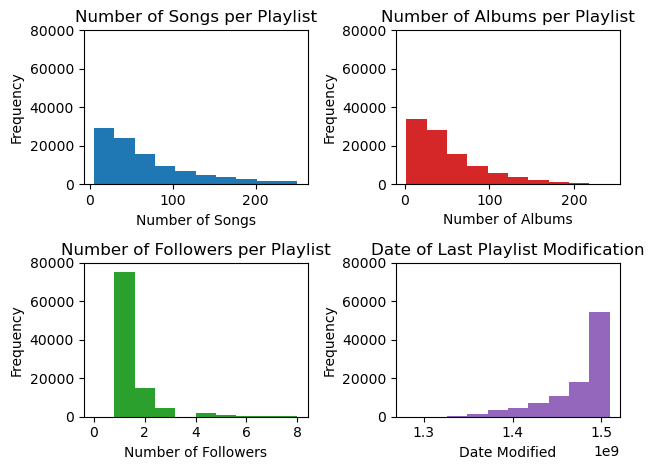

In [147]:
# histograms of different attriubutes of each playlist
  
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

# Histogram of Song Number
ax0.hist(playlistInfoDF['Number of Songs'],histtype='bar', color = 'tab:Blue')
ax0.set_title('Number of Songs per Playlist')
ax0.set_xlabel('Number of Songs') 
ax0.set_ylabel('Frequency') 
ax0.set_ylim([0, 80000])

# Histogram of Album Number
ax1.hist(playlistInfoDF['Number of Albums'],histtype='bar', color = 'tab:Red')
ax1.set_title('Number of Albums per Playlist')
ax1.set_xlabel('Number of Albums') 
ax1.set_ylabel('Frequency')
ax1.set_ylim([0, 80000])

# Histogram of Follower Number
ax2.hist(playlistInfoDF['Number of Followers'], range = (0,8), color = 'tab:green')
ax2.set_title('Number of Followers per Playlist')
ax2.set_xlabel('Number of Followers') 
ax2.set_ylabel('Frequency') 
ax2.set_ylim([0, 80000])

# Histogram of Last Modified
ax3.hist(playlistInfoDF['Last Modified'],histtype='bar', color = 'tab:Purple')
ax3.set_title('Date of Last Playlist Modification')
ax3.set_xlabel('Date Modified') 
ax3.set_ylabel('Frequency') 
ax3.set_ylim([0, 80000])

fig.tight_layout()
plt.show()

The histograms above decribe the distribution of the different numeric variables present for each playlist, which are "Number of Songs", "Number of Albums", "Number of Followers", and "Date of Last Modification". Each of these variables has a right skew, except for date modified which has a left skew. The histogram for number of songs and number of albums indicates that the majority of playlists fall between 0-100 songs and artists. Neither of these fields appear to have a large number of outliers. The number of followers per playlist provides insight on the types of playlists found here. The large majority of playlists have 1-2 followers, indicating that these are likely personal playlists made by users for themselves. There are a very small amount of playlists with over 100 followers which have been excluded from the graph. The final chart indicates that the majortity of playlists are currently being used and modified, due to the frequency of playlists with later dates.  

The key insights provided by these graphs are that the data is not normally distributed with regard to these variables. However, the lack of outliers and missing values suggests that this data quite clean and has likely been preprocessed to some degree already. These charts suggest that we have recent, high-quality data to work with. Further analysis will be done ot establish and use connections between playlists.

## Question 2: Analysis of Playlist & Song Names
Since the dataset provides very little numeric data and analysis of these may likely prove trivial, focus is drawn to playlist names and song names. Since playlist names can vary to wide degree, it seemed most likely to provide interesting results. As explained previously, the majority of these playlists are likely made by individuals like you and me. As such, it may be useful to identify patterns in playlist names, as well as song names. I hypothesize that there are common words used across playlists of similar types, such as "classics" or "party". The individual words present in playlist names could potentially be used as predictors for the songs and artists found in a particular playlist. 

In the code below, the playlist names and song names are extracted from the data and normalized. These are used to create dictionaries and visualizations of word frequencies for each of these variables. The words with the highest count are showcased. 

In [148]:
# This gathers just the playlist names and checks that we have the number of playlists we expect
playlist_names = []
for playlist in playlists:
    playlist_names.append(playlist['name'])
    
print('The number of playlists is: ',len(playlist_names))
print(playlist_names[1:100])

The number of playlists is:  100000
['Awesome Playlist', 'korean ', 'mat', '90s', 'Wedding', 'I Put A Spell On You', '2017', 'BOP', 'old country ', 'abby ', 'VIBE', 'relax', 'sleep', "90's ", 'New Songs', 'slow hands', "Mom's playlist", 'SARAH', 'melancholy', 'mixtape', 'Sad Songs', "fall '17", '✔️', 'Twenty one pilots', 'run it', 'Winter 2014', 'smooth ', 'Yeet', 'groovy', 'Garage Rock', 'Running 2.0', 'acoustic', 'morning', 'good good', 'Good Vibes', ' indie rock', 'Hits', 'tb', 'Country', '2020', 'Belters', "Road Trippin'", 'Country', 'taylor swift', 'angst', 'Running 2', 'Spring 2016', 'Country', 'Gospel', 'SB', 'Kevin', 'Christmas', 'NB', 'Smooth Jazz', 'Tennessee ', 'funky', 'spring 16', 'Gates', 'Favorite Songs', 'Ski', 'Country', 'hype', 'Awesome Mix', 'Elizabeth', 'PlayStation', 'Ashley', 'chill', 'xx', 'art class', 'Random Tunes', 'boat', 'spanish jams', 'new', 'CR', 'Run!!', "winter '17", 'Workout', 'Traps ', 'Dope', 'Chill', 'rap', 'Gospel', 'Florida', 'Workout2', 'Gym', 'Z

In [149]:
# Same as above, but for song names
song_names = []
for playlist in playlists:
    for track in playlist['tracks']:
        song_names.append(track['track_name'])
    
print('The number of songs is: ',len(song_names))
print(song_names[1:100])

The number of songs is:  6677800
['Toxic', 'Crazy In Love', 'Rock Your Body', "It Wasn't Me", 'Yeah!', 'My Boo', 'Buttons', 'Say My Name', 'Hey Ya! - Radio Mix / Club Mix', 'Promiscuous', 'Right Where You Want Me - Radio Edit Version', 'Beautiful Soul', "Leavin'", 'Me & U', 'Ice Box', 'Sk8er Boi', 'Run It!', 'Check On It - feat. Bun B and Slim Thug', "Jumpin', Jumpin'", 'Soak Up The Sun', 'Where Is The Love?', "Stacy's Mom", 'Just The Girl', 'Yo (Excuse Me Miss)', 'Year 3000', 'Lip Gloss', 'Everytime We Touch - Radio Edit', 'Whatcha Say', 'Miss Independent', 'Party In The U.S.A.', 'The Great Escape', 'Replay', 'Forever', 'Your Love Is My Drug', 'Closer', 'One Less Lonely Girl', 'Paper Planes', 'Mr. Brightside', 'All The Small Things', 'Beep', 'Somebody To Love', 'Dirty Little Secret', 'Baby', 'A Thousand Miles', 'Livin on Sunday', 'See You Again', 'How Do You Sleep? - Featuring Ludacris', 'This Is Me', 'My Happy Ending', 'Check Yes Juliet', 'The Great Escape', 'Eye of the Tiger', 'Libe

In [150]:
# Function to tokenize the text in title names
# The result is a list of single words 
def tokenize(titleslist): 
    words = []
    for name in titleslist:
        namesplit = name.split()
        for word in namesplit:
            words.append(word)

    return(words)

In [151]:
# Function to remove stopwords and other words not desired in the list
def filter_words(wordslist):
    stopWords = set(stopwords.words('english')) #  English stop words
    unnecessaryWords = {'(feat.','-','Version','A','The'}
    
    removeWords = stopWords.union(unnecessaryWords)
    
    wordsFiltered = []

    for word in wordslist:
        if word not in removeWords:
            wordsFiltered.append(word)
            
    return(wordsFiltered)

In [152]:
# Makes a dataframe with the word frequencies
def word_freq_df(wordlist, maxNumWords):
    cnt = Counter()
    for word in wordlist:
        cnt[word] += 1

    wordCount = pd.DataFrame(cnt.most_common(maxNumWords), columns = ['word','count'])
    
    return wordCount

In [154]:
# This shows the words found in each of the playlist names after processing
playlist_name_words = filter_words(tokenize(playlist_names))
print(playlist_name_words[:100])

['Throwbacks', 'Awesome', 'Playlist', 'korean', 'mat', '90s', 'Wedding', 'I', 'Put', 'Spell', 'On', 'You', '2017', 'BOP', 'old', 'country', 'abby', 'VIBE', 'relax', 'sleep', "90's", 'New', 'Songs', 'slow', 'hands', "Mom's", 'playlist', 'SARAH', 'melancholy', 'mixtape', 'Sad', 'Songs', 'fall', "'17", '✔️', 'Twenty', 'one', 'pilots', 'run', 'Winter', '2014', 'smooth', 'Yeet', 'groovy', 'Garage', 'Rock', 'Running', '2.0', 'acoustic', 'morning', 'good', 'good', 'Good', 'Vibes', 'indie', 'rock', 'Hits', 'tb', 'Country', '2020', 'Belters', 'Road', "Trippin'", 'Country', 'taylor', 'swift', 'angst', 'Running', '2', 'Spring', '2016', 'Country', 'Gospel', 'SB', 'Kevin', 'Christmas', 'NB', 'Smooth', 'Jazz', 'Tennessee', 'funky', 'spring', '16', 'Gates', 'Favorite', 'Songs', 'Ski', 'Country', 'hype', 'Awesome', 'Mix', 'Elizabeth', 'PlayStation', 'Ashley', 'chill', 'xx', 'art', 'class', 'Random', 'Tunes']


In [155]:
# This shows the words found in each of the song names after processing
song_name_words = filter_words(tokenize(song_names))
print(song_name_words[:100])

['Lose', 'Control', 'Ciara', '&', 'Fat', 'Man', 'Scoop)', 'Toxic', 'Crazy', 'In', 'Love', 'Rock', 'Your', 'Body', 'It', "Wasn't", 'Me', 'Yeah!', 'My', 'Boo', 'Buttons', 'Say', 'My', 'Name', 'Hey', 'Ya!', 'Radio', 'Mix', '/', 'Club', 'Mix', 'Promiscuous', 'Right', 'Where', 'You', 'Want', 'Me', 'Radio', 'Edit', 'Beautiful', 'Soul', "Leavin'", 'Me', '&', 'U', 'Ice', 'Box', 'Sk8er', 'Boi', 'Run', 'It!', 'Check', 'On', 'It', 'feat.', 'Bun', 'B', 'Slim', 'Thug', "Jumpin',", "Jumpin'", 'Soak', 'Up', 'Sun', 'Where', 'Is', 'Love?', "Stacy's", 'Mom', 'Just', 'Girl', 'Yo', '(Excuse', 'Me', 'Miss)', 'Year', '3000', 'Lip', 'Gloss', 'Everytime', 'We', 'Touch', 'Radio', 'Edit', 'Whatcha', 'Say', 'Miss', 'Independent', 'Party', 'In', 'U.S.A.', 'Great', 'Escape', 'Replay', 'Forever', 'Your', 'Love', 'Is', 'My', 'Drug']


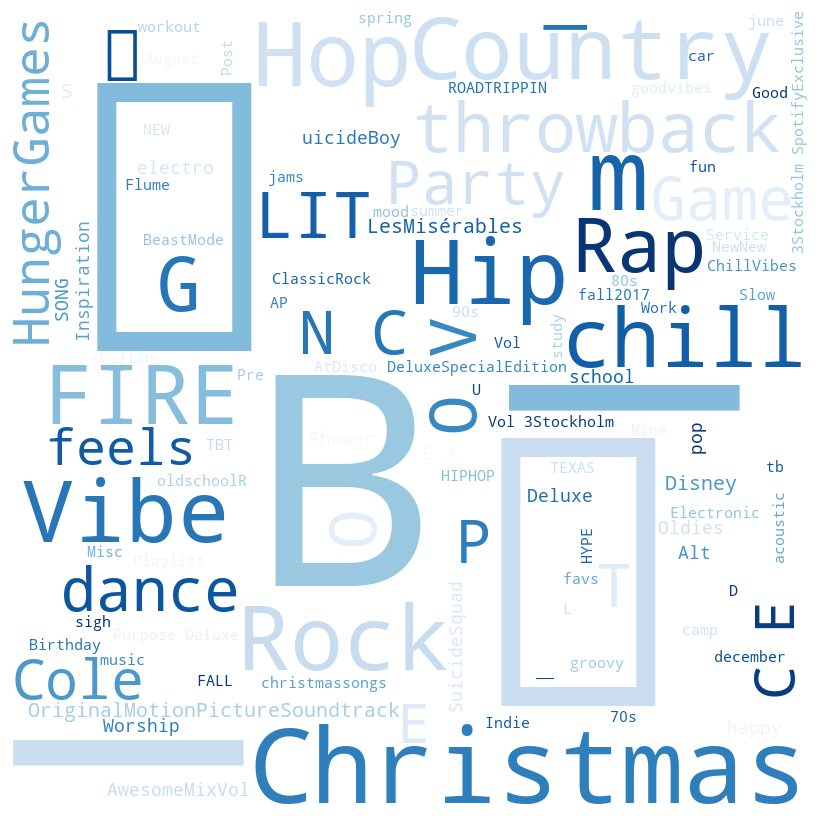

In [157]:
# A wordcloud with the most frequent words used in playlist titles
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10, colormap = "Blues").generate("".join(playlist_name_words))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

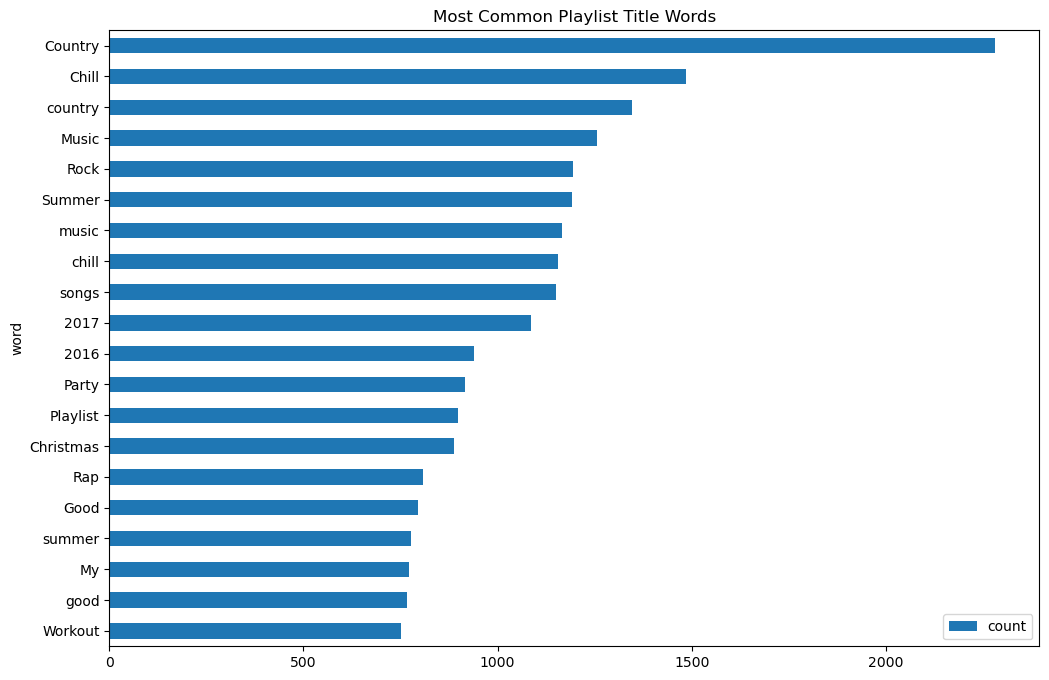

In [158]:
playlistWordCount = word_freq_df(playlist_name_words,20)

fig, ax = plt.subplots(figsize=(12, 8))
playlistWordCount.sort_values(by='count').plot.barh(x='word',
                      y='count',
                      ax=ax,
                      color=['tab:blue'])
ax.set_title("Most Common Playlist Title Words")
plt.show()

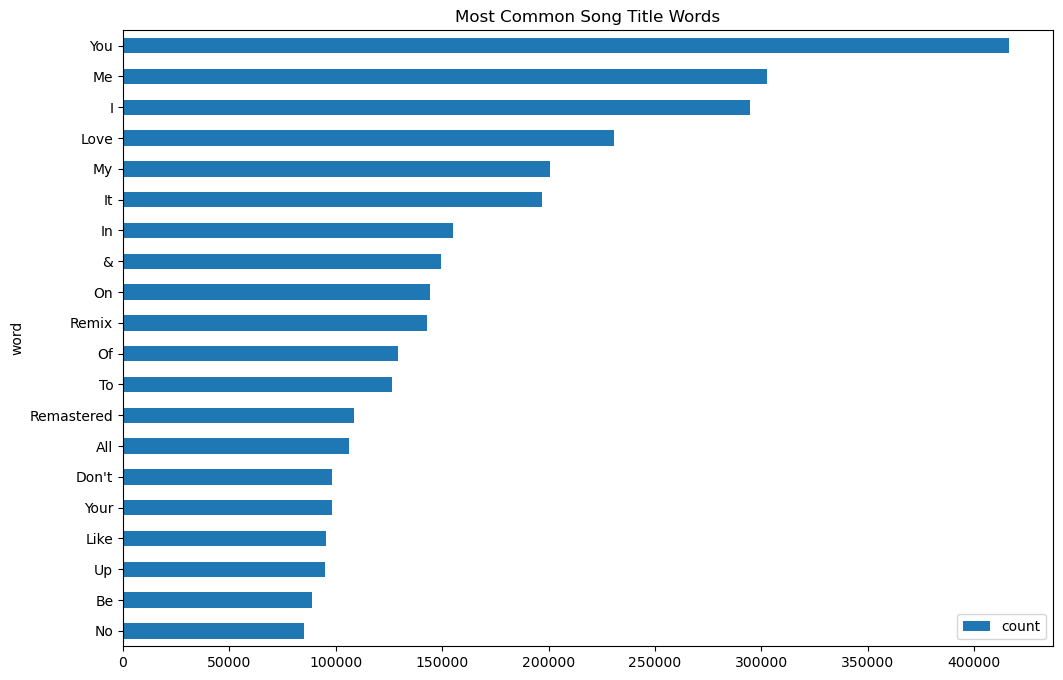

In [159]:
songWordCount = word_freq_df(song_name_words,20)

fig, ax = plt.subplots(figsize=(12, 8))
songWordCount.sort_values(by='count').plot.barh(x='word',
                      y='count',
                      ax=ax,
                      color=['tab:blue'])
ax.set_title("Most Common Song Title Words")
plt.show()

### Analysis of Playlist Names & Song Names
The word cloud and the word frequency charts above highlight patterns found within the playlists data. Primarily, users appear to commonly use genres, times, and occasions for playlist titles such as "Rock", "2015", and "workout". Given the large number of playlists with common words, we can likely find similar songs and trends between playlists with these words. Unfortunately establishing the similarities between these playlists is beyond the scope of this project. Future research should be done to identify if these words are significant predictors of the songs within them. 

The song names provided different insight than the playlist names. As the word frequency chart above highlights, there are many words that are found in song names which are not meaningful, such as "feat.", "&", and "of". Many of these have already been removed during preprocessing. It would likely prove more challenging to gather meaningful insights from the song names. However, particular words like "remastered" or "remix" clearly have connections to particular categories of songs.

## Question 3: Finding Relevant Songs
The final research question explored is whether the playlist data can be used to predict relevant songs for a user. Initially, the data is converted to tabular format for analysis. In addition, a connection is established to Spotify API to gather real time data to supplement. Establishing this connection requires obtaining an API key and installing the spotipy python package. This supplemental data allows the program to gather song and artist data which is subject to change. This allows the program to adapt to changing tastes and provide useful results long-term. In the code below, a couple techniques demonstrate ways in which playlist and song data can be used to find relevant songs. 

The first technique utilizes a playlist and the artists found in that playlist to find relevant songs. The program identifies the artists present and uses this information to indentify other popular songs from those same artists. Since many users likely have the more popular songs from each artist, additional measures are taken to ensure reccomendations are not present in the playlist already. This technique does have limitations which would need to be address at scale. Primarily, this method does not work for playlists with very few songs or very few artists. 

The second technique utlizies one song to find to related songs. This approach differs significantly from the first approach. Instead of using artists and their popularity, it uses the other playlists found in the dataset. The program subsets to only playlists containing that song. From these playlists, the most common songs are identified and provided to the user. This technique shows more promise, as it leverages the trends found from other users.

In [160]:
# This code converts the data from a JSON structure to tabular data for future analysis

songInfo = []

for playlist in playlists:
    
    for track in playlist['tracks']:
        
        songInfo.append((playlist['pid'],
                         track['pos'], 
                         track['track_name'],
                         track['track_uri'], 
                         track['artist_name'], 
                         track['artist_uri'], 
                         track['album_name'], 
                         track['album_uri'], 
                         track['duration_ms']))

playlistDF = pd.DataFrame(songInfo, columns = ['playlistID',
                                               'track_number',
                                               'track_name',
                                               'track_uri',
                                               'artist_name', 
                                               'artist_uri',
                                               'album_name', 
                                               'album_uri', 
                                               'duration_ms'])
playlistDF.head(5)

,playlistID,track_number,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600


In [161]:
# Establishing connection with Spotify's web API
load_dotenv()
SPOTIPY_CLIENT_ID = os.getenv('SPOTIPY_CLIENT_ID')
SPOTIPY_CLIENT_SECRET = os.getenv('SPOTIPY_CLIENT_SECRET')
SPOTIFY_REDIRECT_URI = os.getenv('SPOTIFY_REDIRECT_URI')

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [162]:
def get_top_artists(df, count = 10):
    names = pd.DataFrame(playlistDF['artist_name'].value_counts()[0:count])
    return names

In [163]:
top10_artists = get_top_artists(playlistDF, count = 10)
print(top10_artists)

                count
artist_name          
Drake           82460
Kanye West      40856
Kendrick Lamar  34555
Rihanna         33348
The Weeknd      31147
Eminem          28438
Ed Sheeran      27467
Future          25027
J. Cole         24076
Justin Bieber   23625


In [164]:
# This function will get the most popular songs from artists which are found in the playlist
def get_songs_by_same_artists(playlistID, count):
    
    # retrieves artists from the given playlist
    urilist = playlistDF[playlistDF['playlistID'] == playlistID]['artist_uri'].tolist()
    # retrieves tracks from the given playlist
    songlist = playlistDF[playlistDF['playlistID'] == playlistID]['track_name'].tolist()

    # dictionary to store new songs
    top_related = {}

    # This retrives spotify API data for each of the artists
    for uri in urilist:
        results = spotify.artist_top_tracks(uri, country = 'US')
        # the song data is the part which is used
        tracks = results['tracks']
        
        # This takes the top 3 songs from each artist based on their popularity and adds to top_related
        for track in tracks[:3]:
            top_related.update({track['name']: track['popularity']})
    
    # This removes songs which are already present in the playlist
    for song in list(top_related.keys()):
        if song in songlist:
            del top_related[song]

    # This sorts the songs by popularity and outputs the number requested with Count
    sorted_results= dict(sorted(top_related.items(), key=lambda x:x[1], reverse=True))
    top_reccomended = [k for k in sorted_results.keys()][:10]

    return top_reccomended

In [165]:
# Retrieves 10 songs by related artists based on playlist 1
get_songs_by_same_artists(1, 10)

['Have You Ever Seen The Rain',
 'Paint It, Black',
 'Africa',
 'Bad Moon Rising',
 'Welcome To The Jungle',
 'Start Me Up - Remastered 2009',
 'Paradise City',
 'Wind Of Change',
 'Stairway to Heaven - Remaster',
 'Immigrant Song - Remaster']

In [166]:
# Retrieves 10 songs by related artists based on playlist 2
get_songs_by_same_artists(2, 10)

['FRI(END)S',
 'Love Me Again',
 'Slow Dancing',
 'How You Like That',
 'Dynamite',
 'Left and Right (Feat. Jung Kook of BTS)',
 'ONLY',
 'My Universe',
 'Pink Venom',
 'PARANOIA']

In [167]:
def count_songs(list):
    cnt = Counter()
    for song in list:
        cnt[song] += 1

    songCount = pd.DataFrame(cnt.most_common(), columns = ['song','count'])
    
    return songCount

In [168]:
def get_related_songs(songuri, count):
    # Finds the playlist ID of all playlists which contain this song
    relevantPlaylists = playlistDF[playlistDF['track_uri'] == songuri]['playlistID'].tolist()
    
    # stores all songs from related playlists
    allsongs = []
    
    # subsets the dataframe to just each playlist
    for playlist in relevantPlaylists:
        df = playlistDF[playlistDF['playlistID'] == playlist]
        
        # adds the songs to list, one at a time to avoid a list within lists
        for song in df['track_name']:
            allsongs.append(song)  
    
    # counts the number of times each song appears and returns a dataframe
    songCount = count_songs(allsongs)
    
    # removes the first row, as the most common song will always be the song given and should be removed
    songCount = songCount.drop([0])
    
    # subsets the the n number of songs requested in the function parameters by "Count"
    df2 = songCount[0:count]
    relatedSongs = list(df2['song'])
    
    return relatedSongs

In [169]:
# Retrieves related songs for "Let it Be" by The Beatles
df = get_related_songs('spotify:track:5V1AHQugSTASVez5ffJtFo', 5)
df

['Hey Jude - Remastered 2015',
 'Here Comes The Sun - Remastered',
 'Come Together - Remastered',
 'Piano Man',
 'Bohemian Rhapsody - Remastered 2011']

In [170]:
# Retrieves related songs for "Left Hand Free" by Alt J
df = get_related_songs('spotify:track:4iEOVEULZRvmzYSZY2ViKN', 10)
df

['Breezeblocks',
 'Stolen Dance',
 'Riptide',
 'Every Other Freckle',
 'Tessellate',
 'Do I Wanna Know?',
 'Cigarette Daydreams',
 'Gooey',
 'Electric Feel',
 'Home']

## Conclusion
The insights provided by this analysis shed a great deal of light on the research questions outlined at the start. This analysis showcases that playlist data, particularly that of this quality and quantity, can be used to establish trends and make predictions. This data is particularly clean and ready to process. Even with outliers, this code shows how little data is needed to obtain meaningful results. 

As for the second research question, there are significant trends within playlist names. However, song names did not provide as much meaningful insight. There is potential for both of these to be used togther as predictors of songs with more complex code. Regardless, the trends in playlist names clearly could be utilized in tailoring reccomendations for users. Given more time, I would like to establish correlations between these words and utilize machine learning models which use this data.

The final part of this code provides a clear answer to the last research question. Playlist data has great potential to predict and recommend songs to users. Spotify has already made themselves a leader in their industry by making this a priority. The two techniques shown above have both provided great results in providing recommendations. It is evident that combining this data with similar techniques, and possibly machine learning, have great potential to transform the way people find new music. 